In [27]:
import glob

available_ports = glob.glob("/dev/tty[A-Za-z]*")
print("Available Serial Ports:", available_ports)

Available Serial Ports: ['/dev/ttyUSB0', '/dev/ttyprintk', '/dev/ttyS31', '/dev/ttyS30', '/dev/ttyS29', '/dev/ttyS28', '/dev/ttyS27', '/dev/ttyS26', '/dev/ttyS25', '/dev/ttyS24', '/dev/ttyS23', '/dev/ttyS22', '/dev/ttyS21', '/dev/ttyS20', '/dev/ttyS19', '/dev/ttyS18', '/dev/ttyS17', '/dev/ttyS16', '/dev/ttyS15', '/dev/ttyS14', '/dev/ttyS13', '/dev/ttyS12', '/dev/ttyS11', '/dev/ttyS10', '/dev/ttyS9', '/dev/ttyS8', '/dev/ttyS7', '/dev/ttyS6', '/dev/ttyS5', '/dev/ttyS4', '/dev/ttyS3', '/dev/ttyS2', '/dev/ttyS1', '/dev/ttyS0']


In [28]:
import time, serial, struct
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, clear_output

SERIAL_PORT = "/dev/ttyUSB0"  # Change to match your setup
BAUD_RATE = 115200

In [29]:
def clean_uart():
    with serial.Serial(SERIAL_PORT, BAUD_RATE, timeout=0.5) as ser:
        ser.reset_input_buffer()
        ser.reset_output_buffer()
        return 1

def read_addr(addr):
    with serial.Serial(SERIAL_PORT, BAUD_RATE, timeout=0.5) as ser:
        ser.write(bytes([0xA2]))
        rw_addr = addr | 0x80
        ser.write(bytes([rw_addr]))
        return ser.read(2)

def write_addr(addr, data):
    with serial.Serial(SERIAL_PORT, BAUD_RATE, timeout=0.5) as ser:
        ser.write(bytes([0xA2]))
        ser.write(bytes([addr]))
        ser.write(bytes([data]))
        return ser.read(2)
    
def read_burst():
    with serial.Serial(SERIAL_PORT, BAUD_RATE, timeout=0.5) as ser:
        ser.write(bytes([0xA3]))
        data = ser.read(8)
        return data
    
def twos_complement(value, bits):
    """Convert an integer value to signed two's complement."""
    if value & (1 << (bits - 1)):
        value -= 1 << bits
    return value

def parse_burst(raw):
    # --- X-axis: 13 bits, two's complement
    x_raw = ((raw[1] << 5) | (raw[0] & 0x1F))
    x_val = twos_complement(x_raw, 13)
    
    # --- Y-axis: 13 bits, two's complement
    y_raw = ((raw[3] << 5) | (raw[2] & 0x1F))
    y_val = twos_complement(y_raw, 13)
    
    # --- Z-axis: 15 bits, two's complement
    z_raw = ((raw[5] << 7) | (raw[4] & 0x7F))
    z_val = twos_complement(z_raw, 15)
    
    # --- RHALL: 14 bits unsigned
    rhall_raw = ((raw[7] << 6) | (raw[6] & 0x3F))
    
    # --- Data Ready bit (bit0 of register 0x48)
    data_ready = raw[6] & 0x01
    
    return {
        "X": x_val,
        "Y": y_val,
        "Z": z_val,
        "RHALL": rhall_raw,
        "DataReady": bool(data_ready)
    }

def f_max_ODR(nXY, nZ):
    return 1 / (145e-6 * nXY + 500e-6 * nZ + 980e-6)

In [43]:
# Power control, soft reset and SPI mode control register
pwr_wr = 0x01
write_addr(0x4B, 0x00) # full POR suspend mode
time.sleep(0.1) # 100ms startup time
write_addr(0x4B, 0x83) # Soft reset
time.sleep(0.005) # 5ms startup time
write_addr(0x4B, 0x01)  # Enable power
time.sleep(0.003)
pwr_rd = read_addr(0x4B)[0]
print("Power control register:", pwr_rd == pwr_wr)

# Repetitions control registers
nXY_wr = 3
nZ_wr = 3
write_addr(0x51, nXY_wr)
write_addr(0x52, nZ_wr)
nXY_rd = read_addr(0x51)[0]
nZ_rd = read_addr(0x52)[0]
print("Repetition for nXY register:", nXY_rd == nXY_wr)
print("Repetition for nZ register:", nZ_rd == nZ_wr)
print("Maximum possible data rate:", f_max_ODR(nXY_wr, nZ_wr))


# Operation mode, output data rate and self-test control register
opmode_wr = 0x06
write_addr(0x4C, opmode_wr) # set data rate
opmode_rd = read_addr(0x4C)[0]
print("Operation mode register:", opmode_rd == opmode_wr)

# Interrupt settings and axes enable bits control register
int_wr = 0xBF
write_addr(0x4E, int_wr) # Enable DRDY, x-, y-, and z-axis
int_rd = read_addr(0x4E)[0]
print("Interrupt settings register:", int_rd == int_wr)

Power control register: True
Repetition for nXY register: True
Repetition for nZ register: True
Maximum possible data rate: 343.0531732418525
Operation mode register: True
Interrupt settings register: True


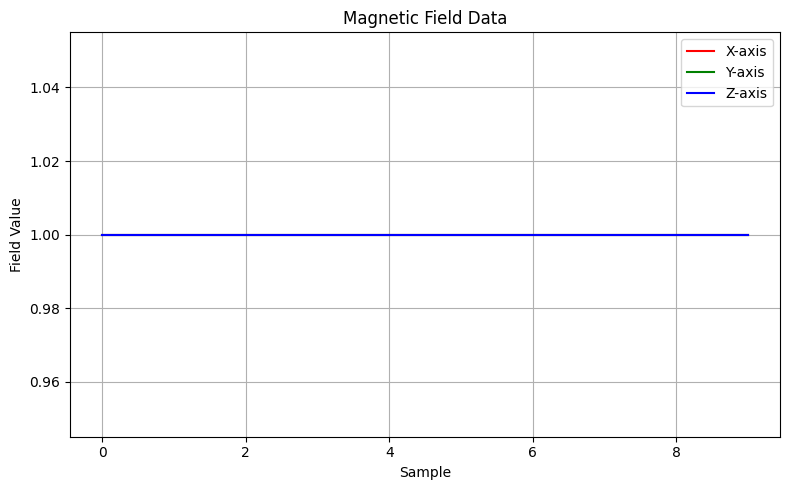

In [44]:
runs = 10

# Initialize
clean_uart()

write_addr(0x4C, 0x00)  # Set Active Mode
time.sleep(1)

x_vals = []
y_vals = []
z_vals = []

plt.figure(figsize=(8, 5))

try:
    for i in range(runs):

        burst_data = read_burst()
        results = parse_burst(burst_data)
        
        # Store data
        x_vals.append(results["X"])
        y_vals.append(results["Y"])
        z_vals.append(results["Z"])
        
        # Clear previous plot
        clear_output(wait=True)
        plt.clf()
        
        # Plot updated data
        plt.plot(x_vals, label="X-axis", color='r')
        plt.plot(y_vals, label="Y-axis", color='g')
        plt.plot(z_vals, label="Z-axis", color='b')
        plt.title("Magnetic Field Data")
        plt.xlabel("Sample")
        plt.ylabel("Field Value")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        
        # Display updated plot
        display(plt.gcf()) 
finally:
    write_addr(0x4C, 0x06)  # Sleep Mode
    plt.close()  # Prevent Jupyter from showing the last static plot


In [39]:
results

{'X': 1, 'Y': 1, 'Z': 1, 'RHALL': 1, 'DataReady': True}

In [65]:
read_addr(0x48).hex()

'01'

In [ ]:
write_addr(0x4C, 0x06)

{'X': 1, 'Y': 1, 'Z': 1, 'RHALL': 1, 'DataReady': True}

# Self test (normal)

In [25]:
write_addr(0x4C, 0x06)  # Sleep mode
time.sleep(0.003)

write_addr(0x4C, 0x07)  # Sleep mode + self-test enable
time.sleep(0.002)       # Wait for test

write_addr(0x4C, 0x06)  # Back to Sleep mode

x_result = read_addr(0x42)[0] & 0x01
y_result = read_addr(0x44)[0] & 0x01
z_result = read_addr(0x46)[0] & 0x01

print("Normal Self-Test Results:",
      f"X={'PASS' if x_result else 'FAIL'}",
      f"Y={'PASS' if y_result else 'FAIL'}",
      f"Z={'PASS' if z_result else 'FAIL'}")

write_addr(0x4C, 0x00)

Normal Self-Test Results: X=PASS Y=PASS Z=PASS


b'\xff'

# Self test (advanced)

In [22]:
write_addr(0x4C, 0x06)
time.sleep(0.003)

write_addr(0x4E, 0x04)  # Example: enable only Z-axis
write_addr(0x52, 0x52)

write_addr(0x4E, 0x05)
write_addr(0x4C, 0x02)
time.sleep(0.01)
burst_pos = parse_burst(read_burst())

write_addr(0x4E, 0x06)



write_addr(0x4C, 0x02)
time.sleep(0.01)
burst_neg = parse_burst(read_burst())
write_addr(0x4E, 0x04)


diff = burst_pos["Z"] - burst_neg["Z"]
print("Advanced Self-Test ΔZ =", diff)

write_addr(0x4B, 0x83)
time.sleep(0.05)


IndexError: index out of range

In [24]:
read_burst().hex()

''

In [40]:
write_addr(0x4B, 0x83)  # Soft reset
time.sleep(0.05)

write_addr(0x4B, 0x01)  # Power on
time.sleep(0.003)

write_addr(0x4C, 0x00)  # Normal mode
write_addr(0x51, 0x17)  # nXY = 23 repetitions
write_addr(0x52, 0x52)  # nZ = 82 repetitions


b'\xff'

In [ ]:
def compensate_x(raw_x, rhall, trim):
    if raw_x == -4096:  # overflow
        return 0
    if rhall == 0:
        rhall = trim["dig_xyz1"]
    process_comp = rhall
    if process_comp != 0:
        process_comp = (trim["dig_xyz1"] * 16384 / process_comp) - 16384
        process_comp = raw_x * (((trim["dig_xy2"] * (process_comp**2) / (1 << 28)) +
                                 (process_comp * trim["dig_xy1"] / 16384) +
                                 256) * (trim["dig_x2"] + 160)) / 8192
        process_comp = (process_comp + (trim["dig_x1"] * 8)) / 16
        return int(process_comp)
    return 0


In [45]:
status = read_addr(0x48)[0]
if status & 0x01:
    burst = read_burst()


In [47]:
burst.hex()

''